In [1]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import utils
import sys

# About

Эта тетрадка - пример запуска алгоритмов диагностирования (**АД**) и предсказания сбоев (**АПС**) СХД, реализованных в библиотеке **nostradamus**, на простых модельных данных.

Задача алгоритмов диагностирования - диагностировать состояние сомпонент СХД и СХД в целом в текущий момент времени на основе исторических данных:

![ad2.png](pics/ad.png)

Задача алгоритмов предсказания сбоев - предсказать вероятности перехода компонента СХД из текущего состояния в другие возможные состояния в течение заданного промежутка времени на основе исторических данных:

![aps.png](pics/aps.png)

С алгоритмической точки зрения, АД и АПС похожи. Они используют одни и те же исторические данные и одинаковые методы их анализа: корреляционный анализ, анализ временных рядов, нейронные сети и т.д..

С точки зрения анализа данных, АД и АПС - разные задачи. Они требуют разного объема исторических данных, других параметров обучения нейронных сетей, например, и, собственно, других обученных моделей.

# Демонстрация на модельных данных

Эти данные не имеют никакого отношения к СХД или к какой-либо симуляции СХД.

# Data generation

In [3]:
data = utils.generate_sample(n_components=2, n_points=2000, random_seed=42)

# Data display

Component 0


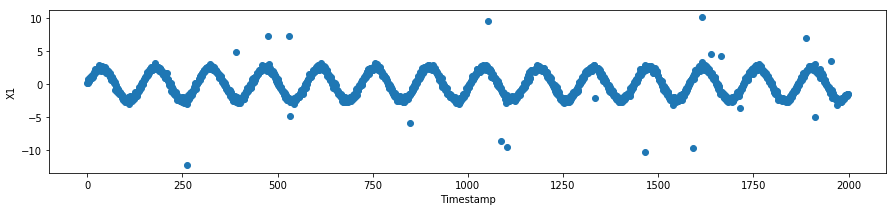

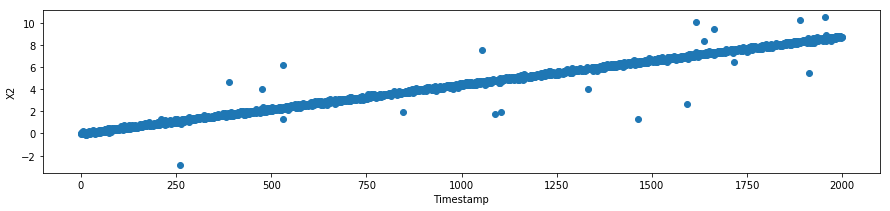

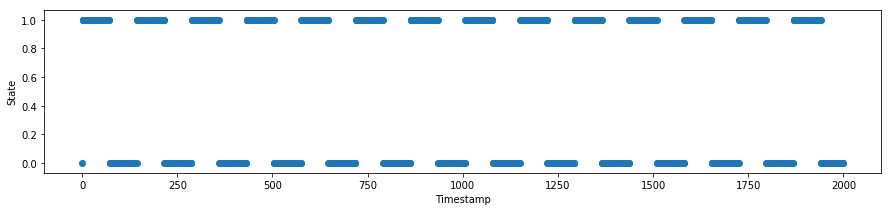

Component 1


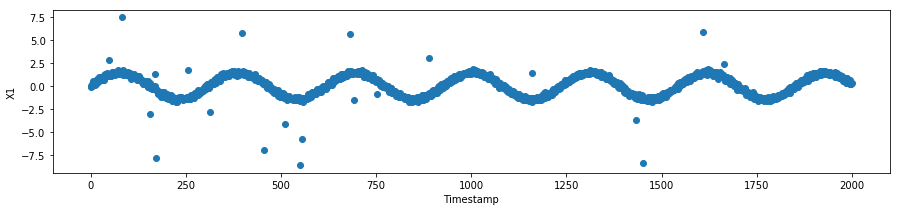

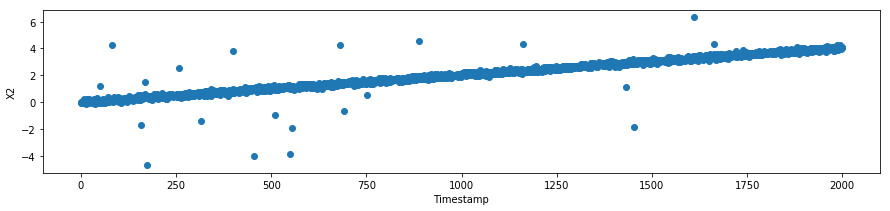

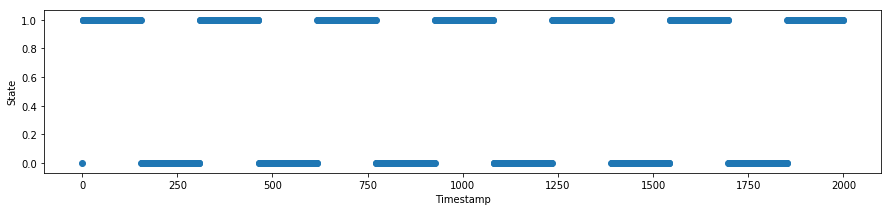

In [4]:
for acomp in data.keys():
    
    data_comp = data[acomp]
    print(acomp)
    
    columns = data_comp.columns[1:]
    for acol in columns:
        plt.figure(figsize=(15, 3))
        plt.scatter(data_comp['Timestamp'].values, data_comp[acol].values)
        plt.xlabel('Timestamp')
        plt.ylabel(acol)
        plt.show()

# Алгоритмы диагностирования

### Train

Для алгоритмов дисагностирования **prediction_horizont = 0**. 

Параметры **window_size** и **slice_size** определяют объем историчеких данных и окно агрегации по времени. Являются входными данными по ТЗ. 

Выбор оптимальной модели диагностирования для каждого компонента и подбор оптимальных парамтеров модели рсуществляется методом **Jarvis** (см. JarvisClassifier в nostradamus).

In [5]:
# sys.path.append('../nostradamus')
from nostradamus.instruments import CrystalBall, FortuneWheel

Using Theano backend.


In [6]:
ad_train = FortuneWheel(window_size=10, 
                        slice_size=10, 
                        prediction_horizont=0, 
                        method='RandomForest')
ad_train.fit(data)
ad_train.save_model('model_ad.pkl')

### Predict

In [7]:
ad_pred = CrystalBall()
ad_pred.load_models('model_ad.pkl')
output = ad_pred.predict(data)

/Users/mikhail91/.virtualenvs/py3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/mikhail91/.virtualenvs/py3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [8]:
# Probabilities for states 0 and 1
output['Component 0'].head()

0      1  Timestamp
0  0.997  0.003         99
1  1.000  0.000        109
2  0.999  0.001        119
3  0.999  0.001        129
4  0.982  0.018        139

Построим результаты диагностирования и сравним с диагностированные состояния с реальными.

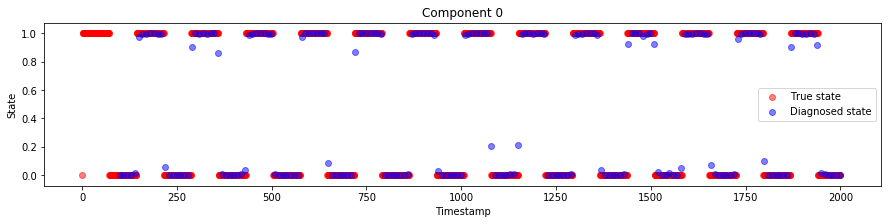

In [9]:
comp = 'Component 0'
comp1_pred = output[comp]
comp1_true = data[comp]

plt.figure(figsize=(15, 3))
plt.scatter(comp1_true['Timestamp'].values, comp1_true['State'].values, label='True state', color='r', alpha=0.5)
plt.scatter(comp1_pred['Timestamp'].values, comp1_pred[1].values, label='Diagnosed state', color='b', alpha=0.5)
plt.legend(loc='best')
plt.xlabel('Timestamp')
plt.ylabel('State')
plt.title(comp)
plt.show()

# Алгоритмы предсказания сбоев

### Train

Для алгоритмов предсказания сбоев **prediction_horizont > 0**. 

Параметры **window_size** и **slice_size** определяют объем историчеких данных и окно агрегации по времени. Являются входными данными по ТЗ. 

Выбор оптимальной модели предсказания для каждого компонента и подбор оптимальных парамтеров модели рсуществляется методом **Jarvis** (см. JarvisClassifier в nostradamus).

In [10]:
window_size = 10 # number of seconds per window
prediction_horizont = 10 # number if windows in future
time_shift = prediction_horizont * window_size
aps_train = FortuneWheel(window_size=10, 
                         slice_size=window_size, 
                         prediction_horizont=prediction_horizont, 
                         method='RandomForest')
aps_train.fit(data)
aps_train.save_model('model_aps.pkl')

### Predict

In [11]:
aps_pred = CrystalBall()
aps_pred.load_models('model_aps.pkl')
output = aps_pred.predict(data)

/Users/mikhail91/.virtualenvs/py3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/mikhail91/.virtualenvs/py3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [12]:
# Probabilities for states 0 and 1
output['Component 0'].head()

0      1  Timestamp
0  0.014  0.986         99
1  0.019  0.981        109
2  0.979  0.021        119
3  0.997  0.003        129
4  0.998  0.002        139

Построим результаты прогнозирования вероятности перехода компонента в состояние **1** через **time_shift** секунд в будущем. 

**Внимание:** на графике timestamp для прогноза нужно сдвинуть на time_shift секунд, чтобы прогноз и реальное состояние компонента совпали.

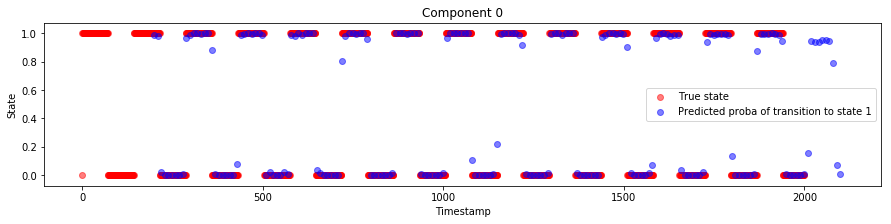

In [13]:
comp = 'Component 0'
comp1_pred = output[comp]
comp1_true = data[comp]

plt.figure(figsize=(15, 3))
plt.scatter(comp1_true['Timestamp'].values, comp1_true['State'].values, label='True state', color='r', alpha=0.5)
plt.scatter(comp1_pred['Timestamp'].values + time_shift, comp1_pred[1].values, label='Predicted proba of transition to state 1', color='b', alpha=0.5)
plt.legend(loc='best')
plt.xlabel('Timestamp')
plt.ylabel('State')
plt.title(comp)
plt.show()

# Демонстрация на данный симулятора СХД

Примерные данные, полученные с помощью первой версии симулятора СХД.

### Data preparation

Чтение данные в формате .json и конвертация в pandas.DataFrame для дальнешего анализа.

In [14]:
import json

def read_json(filepath):
    
    # Read json file
    print('Reading the data ...')
    with open(filepath) as json_data:
        data_raw = json.load(json_data)
    
    # Search for unique storage components
    storage_components = []
    for unit in data_raw:
        for component in unit['storage_components']:
            name = component['name']
            if name not in storage_components:
                storage_components.append(name)
    
    # Print data statistics
    print('Satatistics:')
    print('Number of timestamps: ', len(data_raw))
    print('Number of storage components: ', len(storage_components))
    print('Storage components: ', storage_components)
    
    # Data parsing
    data = {}
    
    # Collect ambience
    lines = []
    for i_unit in range(len(data_raw)):
        unit = data_raw[i_unit]
        timestamp = float(unit['timestamp'])
        ambience = unit['ambience']
        aline = [i_unit, timestamp, 
                 ambience['air_temp'], 
                 ambience['atm_pressure'], 
                 ambience['humidity'], 
                 ambience['vibration']]
        lines.append(aline)
    data['ambience'] = pd.DataFrame(data=lines, 
                                    columns=['N', 'timestamp', 'air_temp', 'atm_pressure', 'humidity', 'vibration'])
        
    # Collect storage components
    for component_name in storage_components:
        lines = []
        for component in data_raw[0]['storage_components']:
            if component['name'] == component_name:
                unit = component
                break
        prop_keys = list(unit['props'].keys())
        cols = ['N', 'timestamp', 'id', 'name', 'anomaly'] + prop_keys
        for i_unit in range(len(data_raw)):
            timestamp = float(data_raw[i_unit]['timestamp'])
            for component in data_raw[i_unit]['storage_components']:
                if component['name'] == component_name:
                    unit = component
                    break
            aline = [i_unit, timestamp, unit['id'], unit['name'], unit['anomaly']]
            for akey in prop_keys:
                prop = unit['props'][akey]
                aline.append(prop)
            lines.append(aline)
        data[component_name] = pd.DataFrame(data=lines, columns=cols)
                

    return data

In [15]:
mc_data_train = read_json('data/server1_fail_1e7_1.json')
mc_data_train = {'Server1': mc_data_train['Server1']}
mc_data_train['Server1'].columns = ['N', 'Timestamp', 'ID', 'Name', 'State', 'Status','DevTemp', 'Uptime', 'Traffic', 'Load']


mc_data_test = read_json('data/server1_fail_1e7_2.json')
mc_data_test = {'Server1': mc_data_test['Server1']}
mc_data_test['Server1'].columns = ['N', 'Timestamp', 'ID', 'Name', 'State', 'Status','DevTemp', 'Uptime', 'Traffic', 'Load']

Reading the data ...
Satatistics:
Number of timestamps:  3999
Number of storage components:  12
Storage components:  ['Server4', 'SSD', 'NetworkSwitch', 'LoadBalancer', 'Anomaly', 'Server3', 'JBOD1', 'JBOD2', 'FabricManager', 'Client', 'Server1', 'Server2']
Reading the data ...
Satatistics:
Number of timestamps:  3999
Number of storage components:  12
Storage components:  ['Client', 'Anomaly', 'Server1', 'Server2', 'JBOD1', 'JBOD2', 'LoadBalancer', 'FabricManager', 'Server3', 'Server4', 'SSD', 'NetworkSwitch']


In [16]:
mc_data_train['Server1'].head()

N  Timestamp       ID     Name  State  Status  DevTemp  Uptime   Traffic  \
0  0        0.1  Server1  Server1    1.0       0       22     0.1  0.000000   
1  1        0.2  Server1  Server1    1.0       0       22     0.2  0.005924   
2  2        0.3  Server1  Server1    1.0       0       22     0.3  0.005308   
3  3        0.4  Server1  Server1    1.0       0       22     0.4  0.005065   
4  4        0.5  Server1  Server1    1.0       0       22     0.5  0.007451   

   Load  
0     0  
1     0  
2     0  
3     0  
4     0

In [17]:
mc_data_train['Server1'] = mc_data_train['Server1'][['Timestamp', 'State', 'DevTemp', 'Traffic', 'Load']]
mc_data_test['Server1'] = mc_data_test['Server1'][['Timestamp', 'State', 'DevTemp', 'Traffic', 'Load']]

### Data display

In [18]:
def plot_time_series(df, x_col, cols):
    
    for acol in cols:
        plt.figure(figsize=(15, 3))
        x = df[x_col].values
        y = df[acol].values
        plt.scatter(x, y, label=acol)
        # plt.plot(x, y, label=acol)
        plt.xlabel(x_col)
        plt.ylabel(acol)
        plt.legend(loc='upper right')
        plt.show

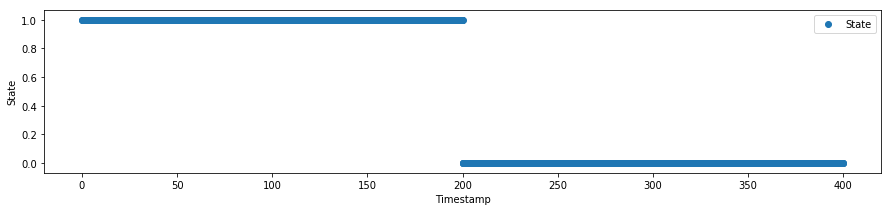

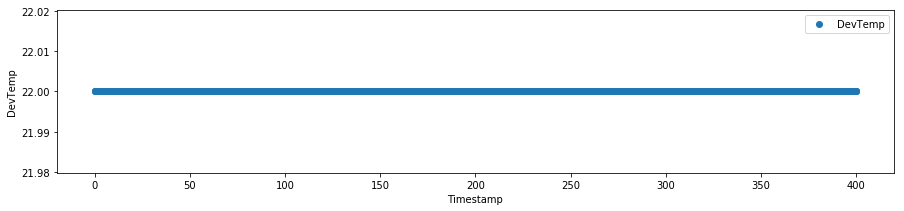

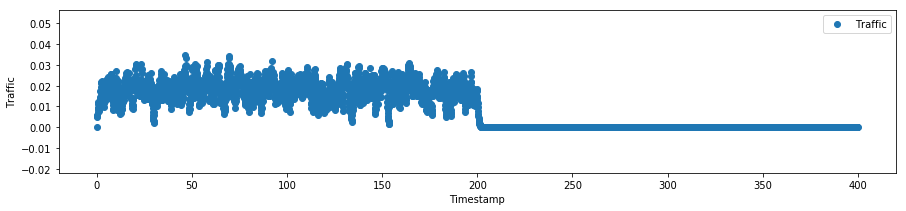

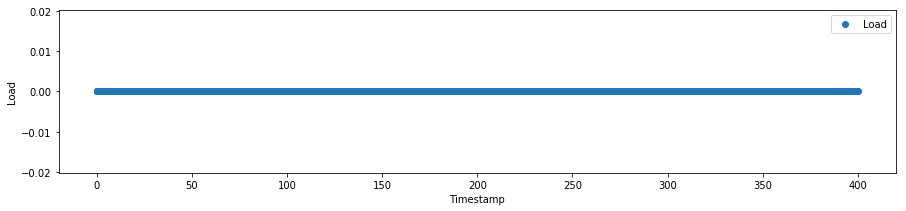

In [19]:
name = 'Server1'
plot_time_series(mc_data_train[name], 'Timestamp', mc_data_train[name].columns[1:])

# Алгоритмы диагностирования

### Train

Для алгоритмов дисагностирования **prediction_horizont = 0**. 

Параметры **window_size** и **slice_size** определяют объем историчеких данных и окно агрегации по времени. Являются входными данными по ТЗ. 

Выбор оптимальной модели диагностирования для каждого компонента и подбор оптимальных парамтеров модели рсуществляется методом **Jarvis** (см. JarvisClassifier в nostradamus).

In [20]:
ad_train = FortuneWheel(window_size=2, 
                        slice_size=2, 
                        prediction_horizont=0, 
                        method='RandomForest')
ad_train.fit(mc_data_train)
ad_train.save_model('mc_model_ad.pkl')

### Predict

In [21]:
ad_pred = CrystalBall()
ad_pred.load_models('mc_model_ad.pkl')
output = ad_pred.predict(mc_data_test)

/Users/mikhail91/.virtualenvs/py3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [22]:
# Probabilities for states 0 and 1
output['Server1'].head()

0.0  1.0  Timestamp
0  0.0  1.0        3.9
1  0.0  1.0        5.9
2  0.0  1.0        7.9
3  0.0  1.0        9.9
4  0.0  1.0       11.9

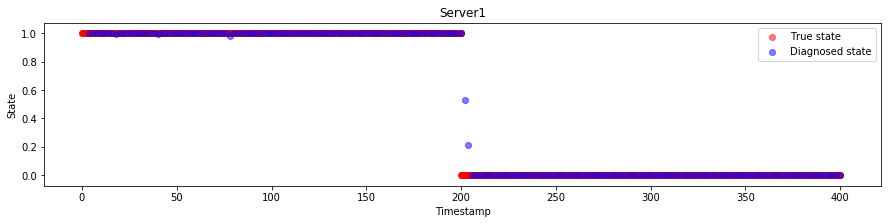

In [23]:
comp = 'Server1'
comp1_pred = output[comp]
comp1_true = mc_data_test[comp]

plt.figure(figsize=(15, 3))
plt.scatter(comp1_true['Timestamp'].values, comp1_true['State'].values, label='True state', color='r', alpha=0.5)
plt.scatter(comp1_pred['Timestamp'].values, comp1_pred[1].values, label='Diagnosed state', color='b', alpha=0.5)
plt.legend(loc='best')
plt.xlabel('Timestamp')
plt.ylabel('State')
plt.title(comp)
plt.show()

# Алгоритмы предсказания сбоев

### Train

Для алгоритмов предсказания сбоев **prediction_horizont > 0**. 

Параметры **window_size** и **slice_size** определяют объем историчеких данных и окно агрегации по времени. Являются входными данными по ТЗ. 

Выбор оптимальной модели предсказания для каждого компонента и подбор оптимальных парамтеров модели рсуществляется методом **Jarvis** (см. JarvisClassifier в nostradamus).

In [24]:
window_size = 2 # number of seconds per window
slice_size = 25 # number of windows
prediction_horizont = 10 # number of windows in future
time_shift = prediction_horizont * window_size
aps_train = FortuneWheel(window_size=window_size, 
                         slice_size=slice_size, 
                         prediction_horizont=prediction_horizont, 
                         method='RandomForest')
aps_train.fit(mc_data_train)
aps_train.save_model('mc_model_aps.pkl')

### Predict

In [25]:
aps_pred = CrystalBall()
aps_pred.load_models('mc_model_aps.pkl')
output = aps_pred.predict(mc_data_test)

/Users/mikhail91/.virtualenvs/py3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [26]:
# Probabilities for states 0 and 1
output['Server1'].head()

0.0    1.0  Timestamp
0  0.181  0.819       49.9
1  0.188  0.812       51.9
2  0.175  0.825       53.9
3  0.189  0.811       55.9
4  0.158  0.842       57.9

Спонтанное отключение сервера невозможно предсказать. Поэтому, АПС не должны работать на данном примере.

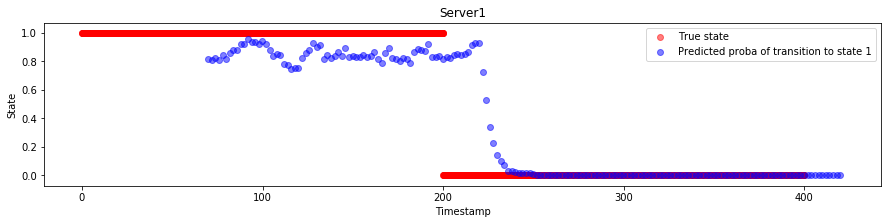

In [27]:
comp = 'Server1'
comp1_pred = output[comp]
comp1_true = mc_data_test[comp]

plt.figure(figsize=(15, 3))
plt.scatter(comp1_true['Timestamp'].values, comp1_true['State'].values, label='True state', color='r', alpha=0.5)
plt.scatter(comp1_pred['Timestamp'].values + time_shift, comp1_pred[1].values, label='Predicted proba of transition to state 1', color='b', alpha=0.5)
plt.legend(loc='best')
plt.xlabel('Timestamp')
plt.ylabel('State')
plt.title(comp)
plt.show()